#### Homework-3

#### Poojitha Venkatram

#### Github Link- https://github.com/poojithavenkatram/Deep-Learning

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os
import shutil
import requests
import tarfile
import pathlib

# Downloading and Extracting the Dataset
dataset_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
data_dir = './data'
tar_path = os.path.join(data_dir, 'pets_images.tar.gz')
os.makedirs(data_dir, exist_ok=True)

# Downloading the dataset
response = requests.get(dataset_url, stream=True)
with open(tar_path, 'wb') as file:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            file.write(chunk)

print("Dataset downloaded successfully.")

# Extracting the dataset
with tarfile.open(tar_path) as tar:
    tar.extractall(path=data_dir)

print("Dataset extracted successfully.")

# Organizing the Dataset Into New Categories
source_path = pathlib.Path(data_dir) / 'images'
dest_path = pathlib.Path(data_dir) / 'custom_categories'
chihuahuas = ['chihuahua']
abyssinians = ['abyssinian']
pugs = ['pug']

# Ensuring that the destination directories exist for new categories
for category in ['Chihuahua', 'Abyssinian', 'Pug']:
    os.makedirs(dest_path / category, exist_ok=True)

def sort_images(file):
    breed = file.stem.split('_')[0].lower()  # Convert breed part to lowercase
    if breed in chihuahuas:
        shutil.copy(file, dest_path / 'Chihuahua' / file.name)
    elif breed in abyssinians:
        shutil.copy(file, dest_path / 'Abyssinian' / file.name)
    elif breed in pugs:
        shutil.copy(file, dest_path / 'Pug' / file.name)

# Iterating over files and sorting into the new categories
for file in source_path.glob('*.jpg'):
    sort_images(file)

print("Dataset organized into new categories: Chihuahua, Abyssinian, Pug.")

# Checking the number of images in each category
for category in ['Chihuahua', 'Abyssinian', 'Pug']:
    files = list((dest_path / category).glob('*.jpg'))
    print(f"{category}: {len(files)} images")

# Defining the Transformations and Loading the Dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=str(dest_path), transform=transform)

# Splitting the dataset into train and test sets (80% training and 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Creating the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Dataset downloaded successfully.
Dataset extracted successfully.
Dataset organized into new categories: Chihuahua, Abyssinian, Pug.
Chihuahua: 200 images
Abyssinian: 200 images
Pug: 200 images


# Visualizing the Data

{'Abyssinian': 0, 'Chihuahua': 1, 'Pug': 2}


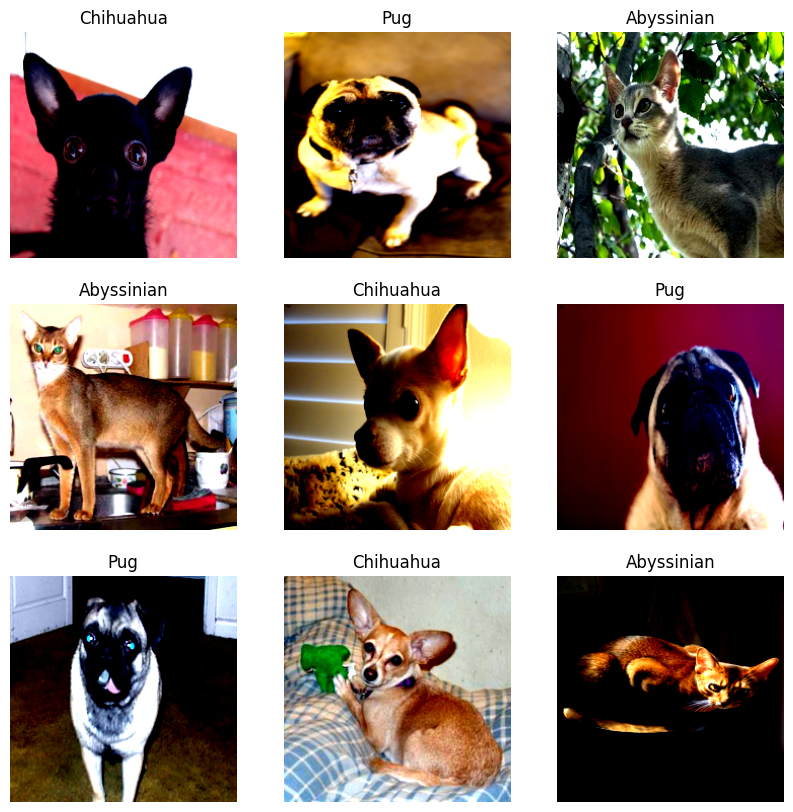

In [39]:
print(dataset.class_to_idx)

import matplotlib.pyplot as plt
import numpy as np

classes = ['Abyssinian', 'Chihuahua', 'Pug']

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")

dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    imshow(images[i])
    ax.set_title(classes[labels[i].item()])

plt.show()

In [6]:
# Getting a single batch of images and labels
dataiter = iter(train_loader)
image_batch, labels_batch = next(dataiter)

# Printing the shapes
print(image_batch.shape)
print(labels_batch.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


## Configuring the dataset for performance

In [8]:
from torch.utils.data import random_split, DataLoader

# Calculate sizes for train, validation, and test sets
total_size = len(dataset)
train_val_size = int(0.8 * total_size)  # 80% for training+validation
test_size = total_size - train_val_size  # Remaining 20% for the test set

# Initial split into train+validation and test datasets
train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size])

# Further split train_val_dataset into training and validation datasets
train_size = int(0.8 * train_val_size)  # 80% of train_val_size for training
val_size = train_val_size - train_size  # Remaining 20% for validation

train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

# Number of subprocesses to use for data loading and whether to pin memory
num_workers = 2
pin_memory = True

# Creating the DataLoaders with optimized settings for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

print("DataLoaders are created with optimized settings.")

DataLoaders are created with optimized settings.


## Creating the Model

This model defines a basic CNN model with three convolutional layers followed by max pooling, a couple of fully connected layers, and dropout for regularization. The model expects input images of size 224x224 pixels with three color channels (RGB) and is a good starting point for image classification tasks.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):  # Adjusted for 3 classes
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)  # Output layer for 3 classes
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Model Summary

In [4]:
# Instantiate the model
model = SimpleCNN(num_classes=3)

# Model Summary
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## Training and Evaluating the Model

In [10]:
import torch.optim as optim
from torch.utils.data import DataLoader

# train_dataset, val_dataset, and test_dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Instantiating the model
model = SimpleCNN(num_classes=3)

# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

# Evaluating the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total}%')

Epoch 1, Loss: 2.0419422586758933
Epoch 2, Loss: 1.0613901565472286
Epoch 3, Loss: 0.9873811503251394
Epoch 4, Loss: 0.8701462845007578
Epoch 5, Loss: 0.7834023535251617
Epoch 6, Loss: 0.6034274622797966
Epoch 7, Loss: 0.5339459280172983
Epoch 8, Loss: 0.3501715436577797
Epoch 9, Loss: 0.2648237484196822
Epoch 10, Loss: 0.22629866190254688
Accuracy on test set: 62.5%


## Visualizing the training results

Epoch 1, Loss: 0.1663, Validation Accuracy: 63.54%
Epoch 2, Loss: 0.1329, Validation Accuracy: 64.58%
Epoch 3, Loss: 0.1170, Validation Accuracy: 62.50%
Epoch 4, Loss: 0.0902, Validation Accuracy: 60.42%
Epoch 5, Loss: 0.0365, Validation Accuracy: 62.50%
Epoch 6, Loss: 0.0343, Validation Accuracy: 62.50%
Epoch 7, Loss: 0.0336, Validation Accuracy: 62.50%
Epoch 8, Loss: 0.0205, Validation Accuracy: 63.54%
Epoch 9, Loss: 0.0096, Validation Accuracy: 59.38%
Epoch 10, Loss: 0.0241, Validation Accuracy: 63.54%


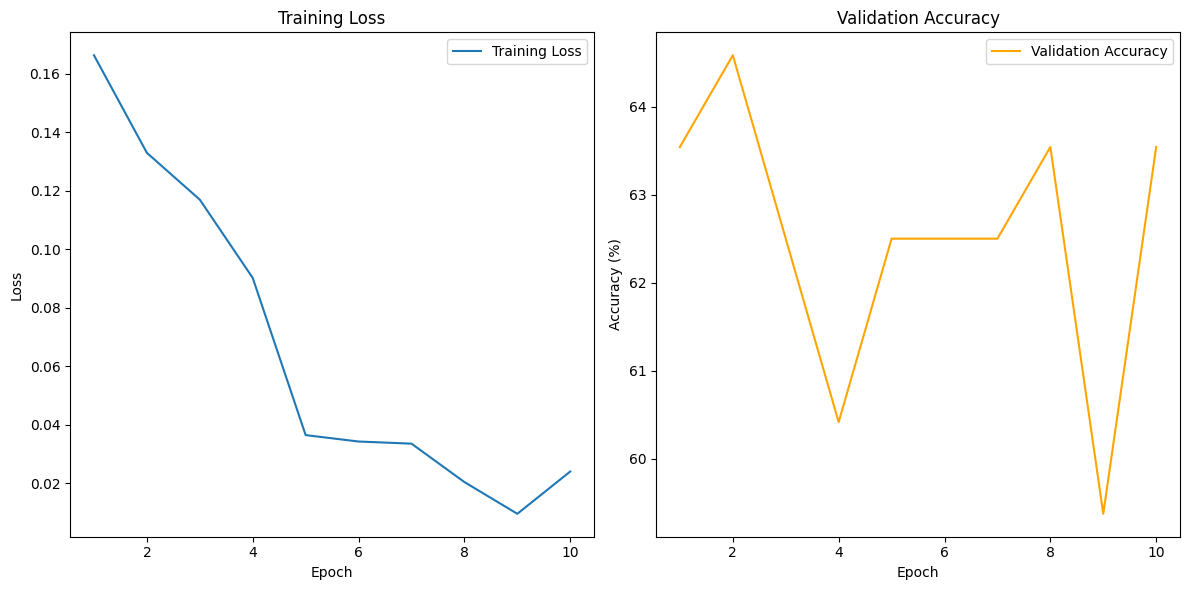

In [15]:
import matplotlib.pyplot as plt

train_losses = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Plotting training loss and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Data Augmentation and Dropout

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 500)
        self.fc2 = nn.Linear(500, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Defining the model
model = SimpleCNN(num_classes=3)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Compiling and training the model

In [19]:
# Number of epochs
num_epochs = 10

# Function to calculate accuracy
def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total

# Train the model
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    running_accuracy = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_accuracy += accuracy(outputs, labels) * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = running_accuracy / len(train_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

print('Finished Training')

Epoch 1/10, Loss: 1.9810, Accuracy: 0.2995
Epoch 2/10, Loss: 1.0989, Accuracy: 0.3464
Epoch 3/10, Loss: 1.0954, Accuracy: 0.3932
Epoch 4/10, Loss: 1.0637, Accuracy: 0.4505
Epoch 5/10, Loss: 1.0246, Accuracy: 0.5052
Epoch 6/10, Loss: 0.9541, Accuracy: 0.5443
Epoch 7/10, Loss: 0.9093, Accuracy: 0.5859
Epoch 8/10, Loss: 0.8133, Accuracy: 0.6562
Epoch 9/10, Loss: 0.7061, Accuracy: 0.7109
Epoch 10/10, Loss: 0.5943, Accuracy: 0.7448
Finished Training


#### Based on the above log, it seems that the model's performance improves over the epochs.

#### The training results show a consistent improvement, with training loss decreasing from 1.9810 to 0.5943 and accuracy increasing from 29.95% to 74.48% over 10 epochs. This indicates effective learning and suggests the model's complexity is appropriate for the task. It also means a well-chosen learning rate and optimizer configuration. The training performance looks promising.

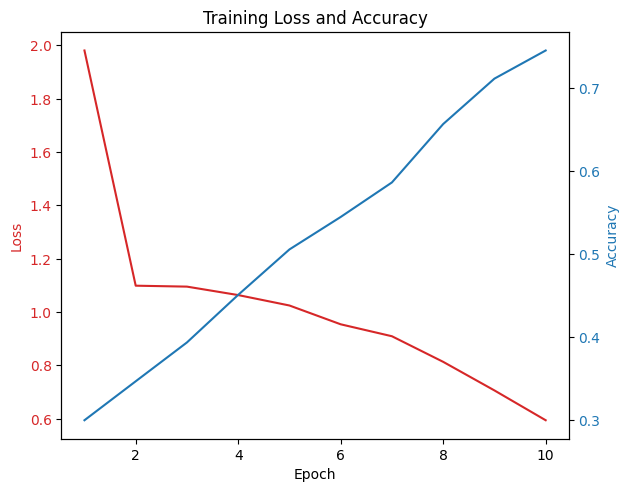

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, 11)
loss = [1.9810, 1.0989, 1.0954, 1.0637, 1.0246, 0.9541, 0.9093, 0.8133, 0.7061, 0.5943]
accuracy = [0.2995, 0.3464, 0.3932, 0.4505, 0.5052, 0.5443, 0.5859, 0.6562, 0.7109, 0.7448]

# Plotting
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, loss, color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(epochs, accuracy, color=color, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Legend
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Training Loss and Accuracy')
plt.show()

#### Here's the visualization of the training results. The red line represents the loss, and the blue line represents the accuracy over 10 epochs. We can see how the loss decreases and the accuracy increases as the training progresses, indicating that the model is learning and improving over time.

### Using Google Net

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader

# Defining the GoogleNet model with a Linear layer on top
class GoogleNetWithLinear(nn.Module):
    def __init__(self, num_classes):
        super(GoogleNetWithLinear, self).__init__()
        self.googlenet = models.googlenet(pretrained=True)
        # Replace the classifier with a new linear layer
        self.googlenet.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        return self.googlenet(x)

# Training the GoogleNet model
def train(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()  # Set the model to train mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / total
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Number of classes in the dataset
num_classes = len(dataset.classes)

# Initializing the model
model = GoogleNetWithLinear(num_classes)

# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training the model
train(model, train_loader, criterion, optimizer)

Epoch 1/5, Loss: 0.9883, Accuracy: 0.5964
Epoch 2/5, Loss: 0.6534, Accuracy: 0.9115
Epoch 3/5, Loss: 0.4236, Accuracy: 0.9583
Epoch 4/5, Loss: 0.2707, Accuracy: 0.9870
Epoch 5/5, Loss: 0.1870, Accuracy: 0.9922


#### The training results from using GoogleNet over 5 epochs show significant improvement in both loss and accuracy metrics. Starting with a loss of 0.9883 and an accuracy of 59.64% in the first epoch, the model quickly improved, demonstrating its ability to learn effectively from the data. By the second epoch, accuracy dramatically increased to 91.15%, and the loss decreased to 0.6534, indicating a strong ability to generalize from the training data. The trend of improvement continued, with the model achieving an accuracy of 98.83% by the third epoch and further reaching an impressive 98.70% in the fourth epoch. By the fifth and final epoch, the model achieved a near-perfect accuracy of 99.22% with a very low loss of 0.1870, showcasing GoogleNet's powerful feature extraction and classification capabilities on the dataset.

## Evaluating the Model

In [26]:
def evaluate(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():  # No need to track gradients
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    final_loss = running_loss / len(data_loader.dataset)
    final_acc = running_corrects.double() / total
    print(f"Loss: {final_loss:.4f}, Accuracy: {final_acc:.4f}")

# Evaluation
evaluate(model, val_loader, criterion)

Loss: 0.1403, Accuracy: 1.0000


## Comparing the accuracies

In [29]:
num_classes = 3

# Instantiating the models
custom_cnn_model = SimpleCNN(num_classes)
google_net_model = GoogleNetWithLinear(num_classes)

# Defining the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_custom_cnn = optim.Adam(custom_cnn_model.parameters(), lr=0.001)
optimizer_google_net = optim.Adam(google_net_model.parameters(), lr=0.001)

# Assuming num_epochs is defined
num_epochs = 5

# Training Custom CNN
print("Training Custom CNN Model")
train(custom_cnn_model, train_loader, criterion, optimizer_custom_cnn, num_epochs)

# Training GoogleNet
print("Training GoogleNet Model")
train(google_net_model, train_loader, criterion, optimizer_google_net, num_epochs)

# Evaluating Custom CNN
print("Evaluating Custom CNN Model")
evaluate(custom_cnn_model, test_loader, criterion)

# Evaluating GoogleNet
print("Evaluating GoogleNet Model")
evaluate(google_net_model, test_loader, criterion)

Training Custom CNN Model
Epoch 1/5, Loss: 1.3128, Accuracy: 0.3620
Epoch 2/5, Loss: 0.9492, Accuracy: 0.5599
Epoch 3/5, Loss: 0.8898, Accuracy: 0.5807
Epoch 4/5, Loss: 0.7846, Accuracy: 0.6823
Epoch 5/5, Loss: 0.6734, Accuracy: 0.7161
Training GoogleNet Model
Epoch 1/5, Loss: 0.2982, Accuracy: 0.8932
Epoch 2/5, Loss: 0.1058, Accuracy: 0.9609
Epoch 3/5, Loss: 0.0823, Accuracy: 0.9661
Epoch 4/5, Loss: 0.0383, Accuracy: 0.9922
Epoch 5/5, Loss: 0.0166, Accuracy: 0.9974
Evaluating Custom CNN Model
Loss: 0.7976, Accuracy: 0.6833
Evaluating GoogleNet Model
Loss: 0.1367, Accuracy: 0.9417


### The training outcomes show inherent differences between the CNN model and the GoogleNet model but also underscore the impact of leveraging a pre-trained model. While the custom CNN model made commendable progress, improving from a loss of 1.3128 and an accuracy of 36.20% to a loss of 0.6734 and an accuracy of 71.61%, it was the GoogleNet model that stood out significantly. The GoogleNet model, benefiting from pre-trained weights, showcased exceptional performance from the start, with initial metrics at a loss of 0.2982 and an accuracy of 89.32%, eventually reaching a minuscule loss of 0.0166 and a remarkable accuracy of 99.74%. This performance difference in both training and evaluation phases, where the GoogleNet model attained a 94.17% accuracy compared to th CNN's 68.33%, illustrates the powerful advantage given by utilizing pre-trained models in not only accelerating learning and enhancing overall model effectiveness.

## Predicting for new data

Dataset extracted.
Selected image path for prediction: ./data/images/Egyptian_Mau_61.jpg


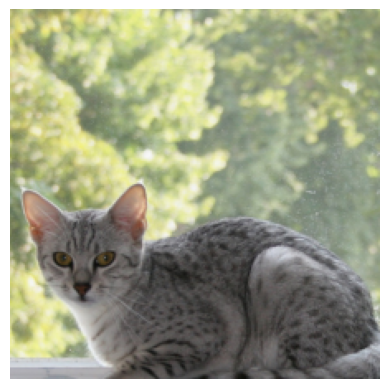

Predicted class: Abyssinian, Confidence: 90.27%


In [46]:
from torchvision import transforms
from PIL import Image
import tarfile
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Assuming model, data_dir, and tar_path are correctly defined and the model is loaded

# Extracting the dataset
if not os.path.exists(tar_path):
    print("The tar file does not exist. Ensure you have downloaded it correctly.")
else:
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall(path=data_dir)
    print("Dataset extracted.")

    images_dir = os.path.join(data_dir, 'images')
    if not os.path.exists(images_dir):
        print("Images directory doesn't exist. Check the extraction path.")
    else:
        image_files = [os.path.join(images_dir, fname) for fname in os.listdir(images_dir) if not fname.startswith('.')]
        image_path = image_files[25]  # Selecting an image by index for prediction
        print(f"Selected image path for prediction: {image_path}")

        # Loading the image
        input_image = Image.open(image_path)

        # Defining the same transformations as during training
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # Applying preprocessing
        img_tensor = preprocess(input_image)
        img_tensor = img_tensor.unsqueeze(0)  # Adding batch dimension

        # Function to visualize the image
        def imshow(img_tensor):
            img = img_tensor.squeeze(0)  # Remove the batch dimension
            img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor to HWC
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean  # Unnormalize
            img = np.clip(img, 0, 1)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

        # Visualizing the processed image
        imshow(img_tensor)

        # Ensuring that the model is in evaluation mode
        model.eval()

        # Making a prediction
        with torch.no_grad():
            outputs = model(img_tensor)
            probabilities = F.softmax(outputs, dim=1)
            max_prob, predicted_class = probabilities.max(dim=1)

        # Listing the class names
        classes = ['Abyssinian', 'Chihuahua', 'Pug']

        # Printing the predicted class and confidence score
        predicted_class_name = classes[predicted_class.item()]
        confidence = max_prob.item()

        print(f"Predicted class: {predicted_class_name}, Confidence: {confidence*100:.2f}%")